In [1]:
# -- Helper python module to open LIGO data files
! wget -q -N https://www.gw-openscience.org/static/sample_code/readligo.py

In [3]:
# -- Download 4096 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.hdf5

^C


In [4]:
# -- Download 32 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126259446-32.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126259446-32.hdf5

In [5]:
# -- Download waveform template
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig2-unfiltered-waveform-H.txt

In [6]:
# -- Download data from Figure 1 of GW150914 detection paper
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-L.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-L.txt

#### Import needed python modules

Most of these are common python packages, and all should be in the IGWN environment.

In [4]:
# Standard python numerical analysis imports:
import numpy as np
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, spectrogram
from scipy.fft import fftshift

import h5py
import json

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

# LIGO-specific readligo.py 
# Download from https://www.gw-openscience.org/static/sample_code/readligo.py
import readligo as rl

We calculate the Power spectral density 

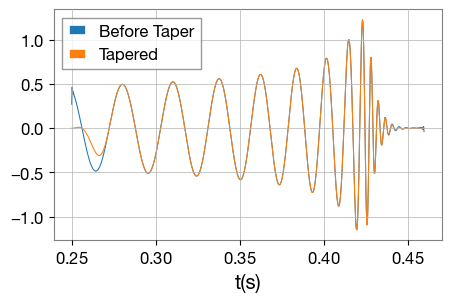

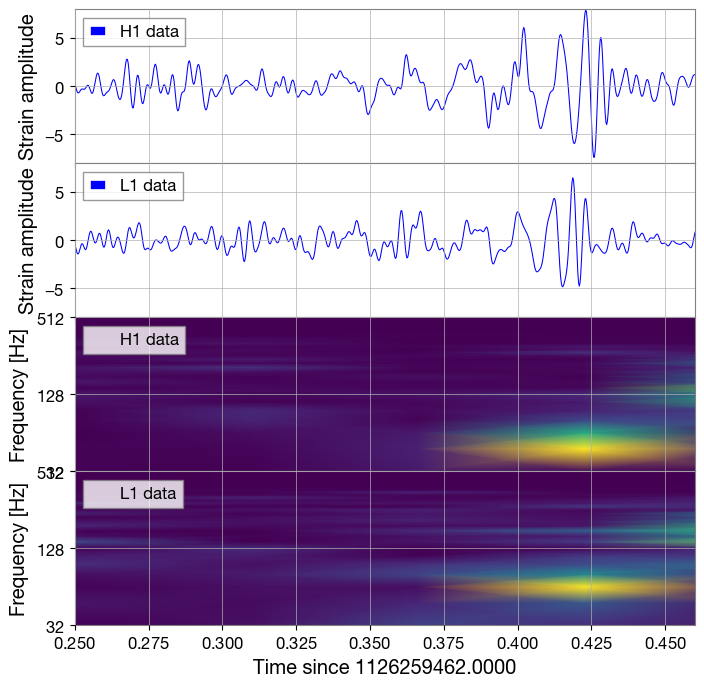

In [5]:
large_data_filenames = {'GW150914': 'LOSC_4_V2-1126257414-4096.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)

def get_full_psds(dir,eventnames, large_data_filenames,
                  make_plots=False, plot_others=False):
    """Obtains full 1024 second psds for all the events specified. Uses the Welch
    average technique, along with other less accurate techniques if
    specified. Can also plot the psd obtained.
    
    Args: 
        eventnames (list): list of events to get psds for
        large_datafilenames (dict): dictionary whose keys are the eventnames 
            and whose values are the filenames of the large amounts of strain
            data used, without the added 'H-<det>_'
        make_plots (bool, optional): if set to True, plot psd data
        plot_others (bool, optional): if set to True, also obtain psd data 
            without averaging as well as with no window
    
    Returns:
        dict: A dictionary containing psds for each detector for each event 
            specified in eventnames.
    """

    large_data_psds = {}
    for eventname in eventnames:
        large_data_psds[eventname] = {'H1': [], 'L1': []}

        # get filename
        fn_H1 = 'H-H1_' + large_data_filenames[eventname]
        fn_L1 = 'L-L1_' + large_data_filenames[eventname]

        # get strain data
        strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
        strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

        # both H1 and L1 will have the same time vector, so:
        time = time_H1

        indxt_around = np.where((time >= time_center - 512) & (
            time < time_center + 512))

        # number of sample for the fast fourier transform:
        NFFT = int( 4 * fs )           # Use 4 seconds of data for each fourier transform
        NOVL = int( 1 * NFFT / 2 )     # The number of points of overlap between segments used in Welch averaging
        psd_window = scipy.signal.tukey(NFFT, alpha=1./4)

        Pxx_H1, freqs = mlab.psd(strain_H1[indxt_around], Fs=fs, NFFT=NFFT,
                                 window=psd_window, noverlap=NOVL)
        Pxx_L1, freqs= mlab.psd(strain_L1[indxt_around], Fs=fs, NFFT=NFFT, 
                                window=psd_window, noverlap=NOVL)
        

        if (plot_others):
            # smaller window if we're not doing Welch's method
            short_indxt_away = np.where((time >= time_center - 2) & (
                time < time_center + 2))
            # psd using a tukey window but no welch averaging
            tukey_Pxx_H1, tukey_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
            # psd with no window, no averaging
            nowin_Pxx_H1, nowin_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, 
                window=mlab.window_none)

        # We will use interpolations of the PSDs computed above for whitening:
        psd_H1 = interp1d(freqs, Pxx_H1)
        psd_L1 = interp1d(freqs, Pxx_L1)

        large_data_psds[eventname]['H1'] = psd_H1
        large_data_psds[eventname]['L1'] = psd_L1

        if make_plots:
            '''fig = plt.figure(figsize=(8, 5))
            # scale x and y axes
            plt.xscale('log', base=2)
            plt.yscale('log', base=10)

            # plot nowindow, tukey, welch together 
            plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window',
                     alpha=.8, linewidth=.5)
            plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window',
                     alpha=.8, linewidth=.5)
            plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.8,
                     linewidth=.5)'''

            # plot 1/f^2
            # give it the right starting scale to fit with the rest of the plots
            # don't include zero frequency
            inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
            # inverse starts at 1 to take out 1/0
            scale_index = 500 # chosen by eye to fit the plot
            scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
            '''plt.plot(nowin_freqs[1:], inverse_square * scale,'red',
                     label= r'$1 / f^2$', alpha=.8, linewidth=1)

            plt.axis([20, 512, 1e-48, 1e-41])
            plt.ylabel('Sn(t)')
            plt.xlabel('Freq (Hz)')
            plt.legend(loc='upper center')
            plt.title('LIGO PSD data near ' + eventname + ' at H1')
            plt.savefig(dir)
            plt.show()'''

    return large_data_psds

eventnames = ['GW150914']
large_data_psds = get_full_psds('./figs/fig0.pdf', eventnames, large_data_filenames,
                                make_plots=False,plot_others=True )

def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp


def get_strain_whitenbp_data(fn_H1, fn_L1, fband, eventname):
    
    # get strain data
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

    # both H1 and L1 will have the same time vector, so:
    time = time_H1

    # whiten, bandpass the data
    strain_H1_whiten = whiten(strain_H1, large_data_psds[eventname]['H1'], dt)
    strain_L1_whiten = whiten(strain_L1, large_data_psds[eventname]['L1'], dt)

    strain_H1_whitenbp = bandpass(strain_H1_whiten, fband, fs)
    strain_L1_whitenbp = bandpass(strain_L1_whiten, fband, fs)
    
    # return results as a dictionary for more intuitive access
    total_data = {'H1': {'strain': strain_H1, 'strain_whiten': strain_H1_whiten,
                         'strain_whitenbp': strain_H1_whitenbp}, 'L1': 
                  {'strain': strain_L1, 'strain_whiten': strain_L1_whiten, 
                   'strain_whitenbp': strain_L1_whitenbp}, 'time': time, 'dt': dt}
                   
    return total_data

def calculate_matched_filter(dir, template_p, eventname, t_amount,
                             total_data, make_plots=False,
                             print_vals=True):
    # these specific values are defined in the paper
    fband = [35.0, 350.0]
    
    time = total_data['time']

    # these dictionaries will be returned with our matched filter data and
    # residuals
    filter_data = {'H1': {}, 'L1': {}}
    
    # amount of data we want to calculate matched filter SNR over- up to 32s
    data_time_window = time[len(time) - 1] - time[0] - (32 - t_amount)

    time_filter_window = np.where((time <= time_center + data_time_window * .5) &
                                  (time >= time_center - data_time_window * .5))
    time_filtered = time[time_filter_window]
    # construct subplot now before looping
    if make_plots:
        fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
        fig.subplots_adjust(hspace=0)
    # loop over the detectors
    dets = ['H1', 'L1']
    for i, det in enumerate(dets):
        strain_whitenbp = total_data[det]['strain_whitenbp'][time_filter_window]

        if make_plots:
            # plot whitened, phase and time shifted templates, data, residuals
            ax = axes[i]
            ax.plot(time_filtered - time_center, strain_whitenbp, 'b',
                    label=det + ' data')
            ax.set_ylim([-8, 8])
            ax.legend(loc='upper left')
            ax.set_ylabel('Strain amplitude')
            
            ax = axes[i + 2]
            f, t, Sxx = spectrogram(strain_whitenbp, 4096)
            t = t - t[0]
            t = t/t[-1]
            t = t*4
            t = t - 2
            ax.pcolormesh(t, f, Sxx, shading='gouraud')

            ax.set_ylabel('Frequency [Hz]')
            #plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
            # plt.specgram(strain_whitenbp,Fs = 2**9,cmap='rainbow')
            ax.plot([], [], ' ', label=det+' data')
            ax.legend(loc='upper left')
            ax.set_yscale('log', base=2)
            ax.set_ylim([32,512])

            plt.xlim([.25, .46])
            #plt.ylabel('Strain amplitude')
            plt.xlabel('Time since {0:.4f}'.format(time_center))
            plt.savefig(dir)
    
    #if make_plots:
        #fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    for i, det in enumerate(dets):
        strain_whitenbp = total_data[det]['strain_whitenbp'][time_filter_window]

        '''if make_plots:
            # plot whitened, phase and time shifted templates, data, residuals
            ax = axes[i]
            f, t, Sxx = spectrogram(strain_whitenbp, 4096)
            plt.pcolormesh(t, f, Sxx, shading='gouraud')
            #plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
            # plt.specgram(strain_whitenbp,Fs = 2**9,cmap='rainbow')
            ax.legend(loc='upper left')
            ax.set_yscale('log', base=2)
            #plt.xlim([.25, .46])
            
            plt.xlim([(.25 + 2)/4*(t[-1]-t[0]) + .125, (.25 + 2)/4*(t[-1]-t[0]) + .125 + (.46-.25)/4*(t[-1]-t[0])])
            plt.ylim([32,512])
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time since {0:.4f}'.format(time_center))
            #plt.savefig(dir)
            print(t)'''
    return filter_data

fn_H1_32 = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_L1_32 = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
total_GW150914_data = get_strain_whitenbp_data(fn_H1_32, fn_L1_32, [35., 350.], 'GW150914')

fig_template = np.genfromtxt('fig2-unfiltered-waveform-H.txt')

# Remove the time vector
fig_template = fig_template[:, 1]

# Downsample this data to 4096 Hz
fig_template = scipy.signal.resample(fig_template, int(len(fig_template)/4) )

# apply a Tukey window to taper the ends of the template
taper_window = signal.tukey(len(fig_template), alpha=.25)
fig_template_tapered = fig_template * taper_window

# -- Plot template before and after tapering
template_time = np.arange(0.25, 0.25+len(fig_template_tapered)*dt,dt)
plt.plot(template_time,fig_template, label='Before Taper')
plt.plot(template_time, fig_template_tapered, label='Tapered')
plt.xlabel('t(s)')
plt.legend()

# Now we need to pad this with 0s to make it the same amount of time as the data
halfdatalen = int(16*fs)
begin_add = halfdatalen - len(fig_template_tapered)

# add last 2048 seconds
fig_template_tapered = np.append(fig_template_tapered, (halfdatalen * [0]))
# add beginning- almost 2048 seconds
fig_template_tapered = np.append((int(begin_add) * [0]), fig_template_tapered)
plt.savefig('./figs/fig3.pdf')
matched_filter_data = calculate_matched_filter('./figs/fig0.png',
    fig_template_tapered, 'GW150914', 4, total_GW150914_data, make_plots=True)

In [1]:
import numpy
# %conda install gwpy
from gwpy.timeseries import TimeSeries

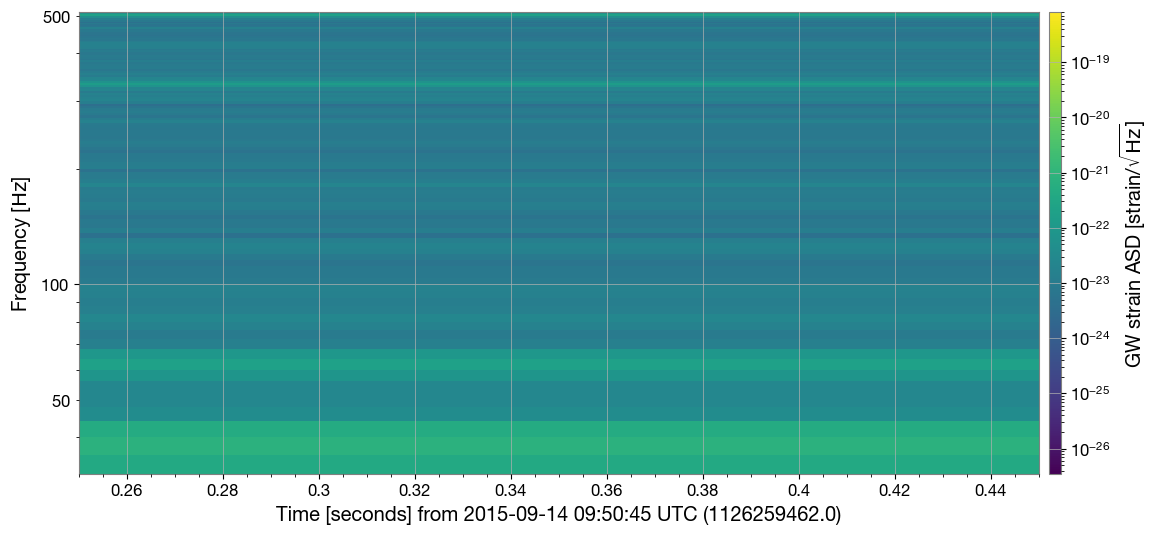

In [69]:
testpath = 'H-H1_LOSC_4_V2-1126257414-4096.hdf5'

offset = 300
stride = offset
fftlen = .5*stride
ol = .5*fftlen

gwdata = TimeSeries.read(testpath, format="hdf5.gwosc", start= time_center-offset, end= time_center+offset)

specgram = gwdata.spectrogram(stride, fftlength=fftlen, overlap = ol) ** (1/2.)

plot = specgram.plot(norm='log', xscale='seconds')
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label='GW strain ASD [strain/$\sqrt{\mathrm{Hz}}$]')
plt.xlim(time_center+.25, time_center+.45)
plt.ylim(32,512)
plt.savefig('./figs/fig1.png')
plot.show()